# User rating based on the review - TF-IDF

## Imports

In [1]:
# Standard library
import pickle
import re
from string import punctuation

# Preprocessing
import nltk
nltk.download("stopwords", quiet=True)

import progressbar
import stop_words
from pymystem3 import Mystem

# Math and visualization
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook", font_scale=1.1)

import vapeplot
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from wordcloud import WordCloud

# Training and evaluation
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Misc
from warnings import filterwarnings
filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Preparation

In [2]:
with open("auxiliary/reviews_dataset.pkl", "rb") as f:
    X, y = pickle.load(f)

X[:6]
y[:6]

['Потрясающе красивая графика космоса! Уже за это игру можно полюбить. Так же в наличии интересный осмысленный сюжет и удобное управление.',
 'Один из наиболее заметных трудов в области теоретической антропологии и этнографии. Язык изложения доступен и качество перевода достойно замечательной серии "Этнографическая библиотека".',
 'Отличное продолжение отличной игры!',
 'Графика неплохая, но в остальном скучно!! Тупо за время нужно проехать определенный участок с не очень хорошим управлением!! У меня не вызвало никаких приятных ощущений от игры!! Только графика!',
 'Все-таки не удержался написать, топ мой скорей всего сотрут, но вдруг кто прочтет, и то хорошо.Такой ужасной игры как "Star Wars: Empire At War (DVD)" ещё поискать надо, нет нормального сюжета, как стратегия - это вовсе провал. Я давно убедился, что всё, за что берётся 1С (в плане игр) - всегда отстой.Хорошая стратегия в по эпизодам Star Wars это "Star Wars Galactic Battlegrounds" - тот кто играл, меня поймет.',
 'Великолеп

[5, 5, 5, 3, 1, 5]

### Preprocessing

In [3]:
# Initializing stuff beforehand for performance.
# When stripping punctuation, we'll use a whitespace and not an empty string in the table
# to avoid concatenating words when whitespace is missing after a punctuation mark
table = str.maketrans({key: " " for key in punctuation})

# Create lemmatizer and stopwords list
mystem = Mystem()

# Compile list of stopwords
stops = set(
    nltk.corpus.stopwords.words("russian")
    + stop_words.get_stop_words("russian")
    + ["свой"]
)


def preprocess(text):
    # Strip punctuation
    text = text.translate(table)

    # Convert all numbers to empty strings
    text = re.sub(r"\d+", "", text)

    tokens = mystem.lemmatize(text.lower())
    tokens = [
        token
        for token in tokens
        if token not in stops and token != " " and token.strip() not in punctuation
    ]
    text = " ".join(tokens)
    return text

In [4]:
X_prep = []

bar = progressbar.ProgressBar(
    maxval=len(X),
    widgets=[progressbar.Bar("=", "[", "]"), " ", progressbar.SimpleProgress()],
)
_ = bar.start()
for idx, item in enumerate(X):
    X_prep.append(preprocess(item))
    bar.update(idx + 1)
bar.finish()

X = X_prep

[============================================================] 769251 of 769251


In [5]:
X[:6]

['потрясающе красивый график космос игра полюбить наличие интересный осмысленный сюжет удобный управление',
 'заметный труд область теоретический антропология этнография язык изложение доступный качество перевод достойный замечательный серия этнографический библиотека',
 'отличный продолжение отличный игра',
 'графика неплохой остальное скучно тупо проехать определенный участок хороший управление вызывать никакой приятный ощущение игра график',
 'таки удерживаться написать топ скоро стереть прочитывать ужасный игра star wars empire at war dvd поискать нормальный сюжет стратегия вовсе провал убеждаться браться план игра отстой хороший стратегия эпизод star wars star wars galactic battlegrounds играть понимать',
 'великолепный график космос планета весьма интересный кампания империя альянс повстанец правда лицензионный версия империя отсутствовать огнетрупер огненный штурмовик вооружать бластер огнемет красный броня создавать планета вулканический климат эйтный ii шол салласт отсутствова

Let's dump our preprocessed text data to a separate pickle file since we might have to reuse it later.

In [6]:
with open("auxiliary/reviews_dataset_preprocessed.pkl", "wb") as f:
    pickle.dump(X, f)

### TF-IDF representation

In [7]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)
features = np.array(tfidf.get_feature_names())

## Word importance

Let's take the look at the most important words across the whole corpus.

In [8]:
def top_mean_feats_for_class(X_tfidf, y, features, clss, top_n=25):
    """Returns the top n features that on average are most important amongst documents
    for a given class."""
    ids = np.where(np.array(y) == clss)
    feats_df = top_mean_feats(X_tfidf, features, ids, top_n=top_n)
    return feats_df


def top_mean_feats(X_tfidf, features, grp_ids=None, top_n=25):
    """Returns the top n features that on average are most important amongst documents in rows
    indentified by indices in grp_ids."""
    if grp_ids:
        D = X_tfidf[grp_ids]
    else:
        D = X_tfidf

    # Finding averages only of non-zero elements of sparse matrix turned out to make less sense
    # than finding overall means when visualizing results, because in that case features
    # that on average are most important seem to be very specific and rare
    tfidf_means = np.squeeze(np.asarray(np.mean(D, axis=0)))
    return top_tfidf_feats(tfidf_means, features, top_n)


def top_tfidf_feats(row, features, top_n=25):
    """Gets top n tfidf values in row and return them with their corresponding feature names."""
    topn_ids = np.argsort(row.data).flatten()[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ["feature", "tfidf"]
    return df

In [9]:
N_BARPLOT = 25
N_WORDCLOUD = 200
BARPLOT_DIMS = (11.7, 8.27)
WORDCLOUD_DIMS = (10, 10)


def generate_bar_plot(feats_df, colormap=None):
    fig, ax = plt.subplots(figsize=BARPLOT_DIMS)
    sns.barplot(x="tfidf", y="feature", data=feats_df, orient="h", palette=colormap)
    ax.set_title(f"{N_BARPLOT} Most Important Words")
    ax.set(xlabel="Mean TF-IDF", ylabel="")


def generate_wordcloud(feats_df, mask=None, colormap=None, contour_color=None):
    wc = WordCloud(
        background_color="white",
        width=1024,
        height=720,
        mask=mask,
        max_words=N_WORDCLOUD,
        colormap=colormap,
        contour_width=5,
        contour_color=contour_color,
    )
    wc_array = wc.generate_from_frequencies(
        dict(zip(feats_df.feature, feats_df.tfidf))
    ).to_array()

    fig, ax = plt.subplots(figsize=WORDCLOUD_DIMS)
    plt.imshow(wc_array, interpolation="bilinear")
    ax.axis("off")

### Negative reviews

In [10]:
neg_feats_df = top_mean_feats_for_class(X_tfidf, y, features, clss=1, top_n=N_WORDCLOUD)

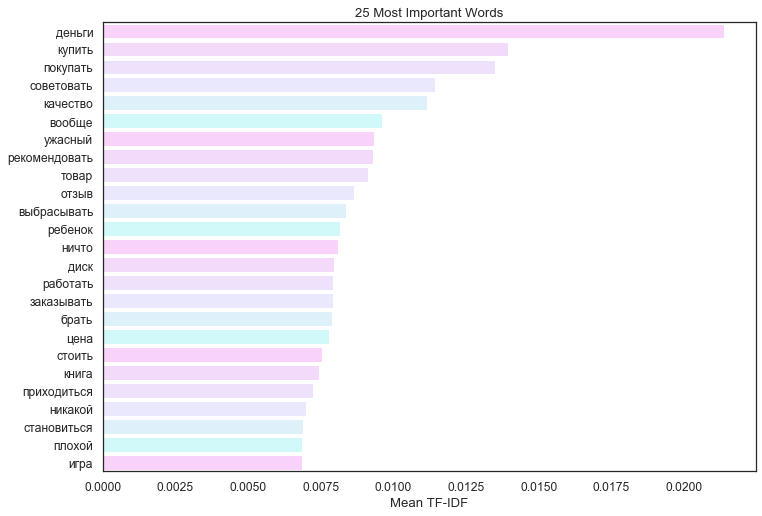

In [11]:
cmap = sns.blend_palette(vapeplot.palette("crystal_pepsi"))
generate_bar_plot(neg_feats_df[:N_BARPLOT], colormap=cmap)

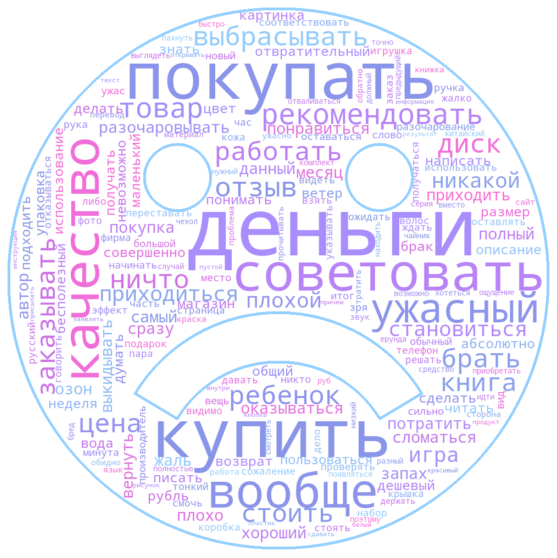

In [12]:
sad_mask = np.array(Image.open("wordcloud-masks/sad-smiley.png"))
cmap = LinearSegmentedColormap.from_list(_, vapeplot.palette("cool"))
generate_wordcloud(neg_feats_df, mask=sad_mask, colormap=cmap, contour_color="#94D0FF")

### Positive reviews

In [13]:
pos_feats_df = top_mean_feats_for_class(X_tfidf, y, features, clss=5, top_n=N_WORDCLOUD)

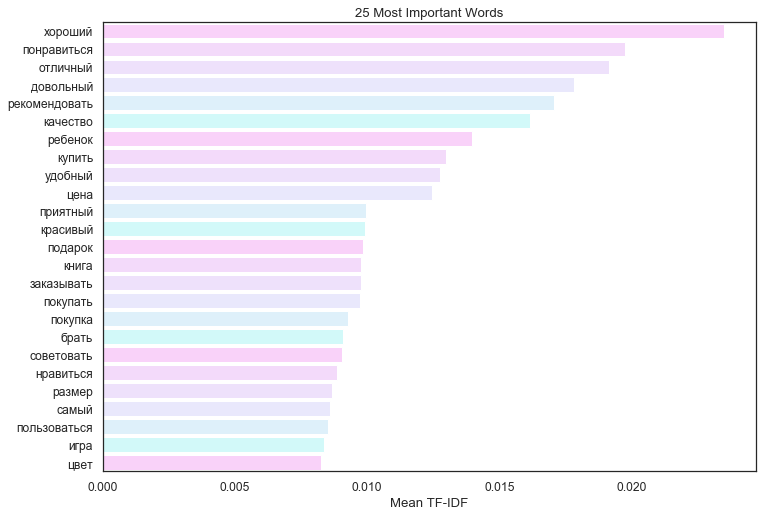

In [14]:
cmap = sns.blend_palette(vapeplot.palette("crystal_pepsi"))
generate_bar_plot(pos_feats_df[:N_BARPLOT], colormap=cmap)

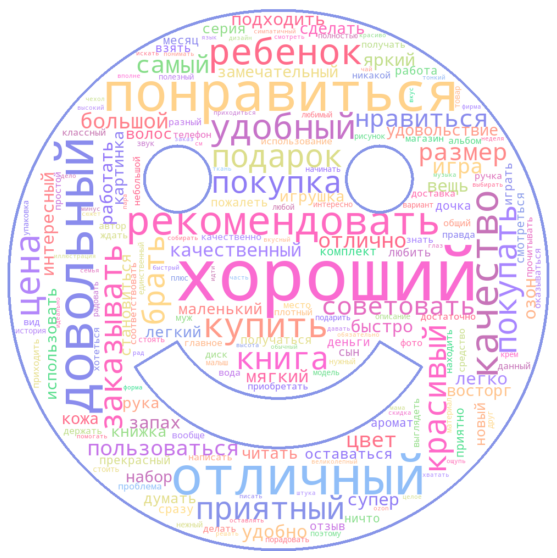

In [15]:
happy_mask = np.array(Image.open("wordcloud-masks/happy-smiley.png"))
cmap = LinearSegmentedColormap.from_list(_, vapeplot.palette("vaporwave"))
generate_wordcloud(pos_feats_df, mask=happy_mask, colormap=cmap, contour_color="#8795E8")

## Training

Now let's train our model on TF-IDF representation and check its performance on the test set.

We won't be using cross validation here, so that when we'll be training neural nets for the same task later on we'll have the same training and evaluation setup, and cross validating NNs training would take too long.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=37, stratify=y
)

In [17]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)

model = LogisticRegression(solver="lbfgs", multi_class="multinomial")
model.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
text_clf = Pipeline([("tfidf", tfidf), ("model", model)])
y_pred = text_clf.predict(X_test)
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")

Accuracy: 0.7122280648159584


In [19]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.53      0.50      0.51     11066
           2       0.28      0.03      0.06      6472
           3       0.35      0.17      0.23     11845
           4       0.41      0.19      0.26     22133
           5       0.77      0.95      0.85    102335

    accuracy                           0.71    153851
   macro avg       0.47      0.37      0.38    153851
weighted avg       0.65      0.71      0.66    153851



We can see that our model is more accurate on very negative and especially very positive reviews and less so on the ones in the middle, which is explainable since reviews with average scores are probably expected to have borders blurred between them in terms of sentimental coloration, which makes it harder for a model to make a correct prediction.